# Sample model monitoring report
Sample reported generated using the `TemporalValidation` and `DataDrift` classes. This code accompanies the paper **The importance of model governance in clinical AI models: case study on the relevance of data drift detection** *, van der Vorst et al. [BMJ Digital Health & AI 2025:1e000046](https://doi.org/10.1136/bmjdhai-2025-000046)*

Install all packages using `pip install -r requirements_full.txt` or `uv sync --all-extras`

In [ ]:
# General imports

import mlflow
from pathlib import Path
import pandas as pd
import plotly.io as pio

pio.renderers.default = "notebook+pdf"
%matplotlib inline

In [ ]:
# Model monitoring code imports
from model_monitoring.temporal_validation import TemporalValidation
from model_monitoring.data_monitoring import DataDriftMonitor

Raw data used to generate this report cannot be shared due to patient confidentiality. Data is loaded using a custom script.

In [ ]:
from load_data import (
    CATEGORICAL_FEATURES_RENAMED,
    RENAME_LABELS_DICT,
    X_test,
    X_train,
    y_test,
    MLFLOW_REGISTRY_LOCATION,
)

## 1. Temporal validation

In [ ]:
# Define performance limits using cross validation metrics
validation_score_mean = {"mean_ROC": 0.82, "std_ROC": 0.02, "mean_Brier": 0.158, "std_Brier": 0.01}

mean_AUC = validation_score_mean["mean_ROC"]
AUC_SD = validation_score_mean["std_ROC"]
auc_lower_limit = mean_AUC - (3 * AUC_SD)

mean_brier = validation_score_mean["mean_Brier"]
brier_SD = validation_score_mean["std_Brier"]
brier_upper_limit = mean_brier + (3 * brier_SD)

# Load best candidate model from mlflow model registry
mlflow.set_tracking_uri(f"sqlite:///{Path.cwd().parent}/{MLFLOW_REGISTRY_LOCATION}")
xgb_best_model = mlflow.sklearn.load_model("runs:/979a6af2420a44258c53b84c03b8ba6e/model")

models = {
    "XGBoost": xgb_best_model,
}

INFO:alembic.runtime.migration:Context impl SQLiteImpl.
INFO:alembic.runtime.migration:Will assume non-transactional DDL.


In [ ]:
# Data for temporal validation should be a dataframe containing both input features and the output
test_data = pd.merge(X_test, y_test, left_index=True, right_index=True)

temporal_validation = TemporalValidation(
    models=models,
    target_column="safe_discharge",
    date_column="admission_start_time",
    rolling_window=1,
    auc_lower_limit=auc_lower_limit,
    brier_upper_limit=brier_upper_limit,
    chunk_period="M",
)

### Periodic metrics

In [ ]:
performance_df = temporal_validation.calculate_period_performance(test_data)
# Display the ROCAUC and Brier score
with pd.option_context("display.max_rows", 50, "display.float_format", "{:.3f}".format):
    display(performance_df)


auc_XGBoost  brier_XGBoost
Month                              
2020-01        0.848          0.158
2020-02        0.852          0.158
2020-03        0.733          0.170
2020-04        0.869          0.160
2020-05        0.834          0.150
2020-06        0.774          0.188
2020-07        0.818          0.171
2020-08        0.875          0.153
2020-09        0.863          0.130
2020-10        0.882          0.128
2020-11        0.899          0.124
2020-12        0.759          0.204
2021-01        0.785          0.169
2021-02        0.848          0.147
2021-03        0.721          0.194
2021-04        0.763          0.190
2021-05        0.856          0.140
2021-06        0.778          0.181
2021-07        0.860          0.151
2021-08        0.818          0.170
2021-09        0.855          0.144
2021-10        0.898          0.129
2021-11        0.770          0.176
2021-12        0.772          0.183
2022-01        0.872          0.149
2022-02        0.852          0.142
2022-03        0.855          0.137
2022-04        0.803          0.164
2022-05        0.807          0.175
2022-06        0.817          0.138
2022-07        0.844          0.150
2022-08        0.765          0.155
2022-09        0.867          0.123

### Performance alerts
Outputs a dataframe with alerts where the performance of a specific period crosses a certain threshold.

In [ ]:
alerts = temporal_validation.get_performance_alerts()
with pd.option_context("display.max_rows", 50, "display.float_format", "{:.3f}".format):
    display(alerts)

value    model  threshold direction
type  Month                                       
ROAUC 2020-03  0.733  XGBoost      0.760     lower
      2020-12  0.759  XGBoost      0.760     lower
      2021-03  0.721  XGBoost      0.760     lower
Brier 2020-12  0.204  XGBoost      0.188    higher
      2021-03  0.194  XGBoost      0.188    higher
      2021-04  0.190  XGBoost      0.188    higher

### ROAUC and Calibration plot
Plots of performance over the entire period

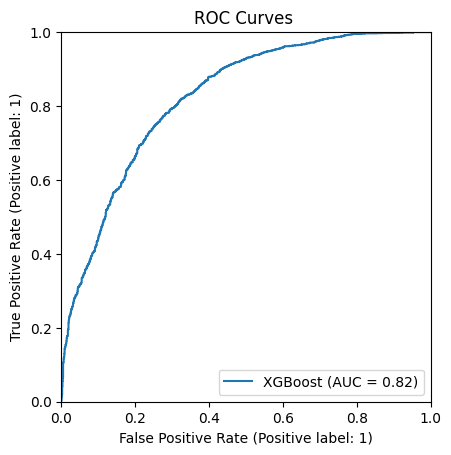

In [ ]:
fig = temporal_validation.plot_roc_curves(data=test_data)
fig.show()

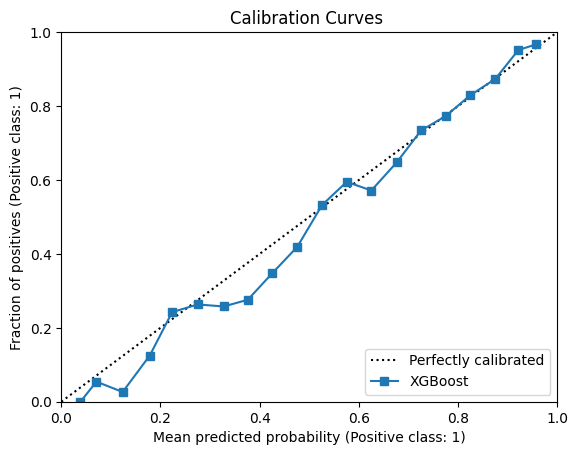

In [ ]:
fig = temporal_validation.plot_calibration_curves(data=test_data)
fig.show()

### Period performance plot
Plot performance over time showing pre-defined limits and where limits are reached

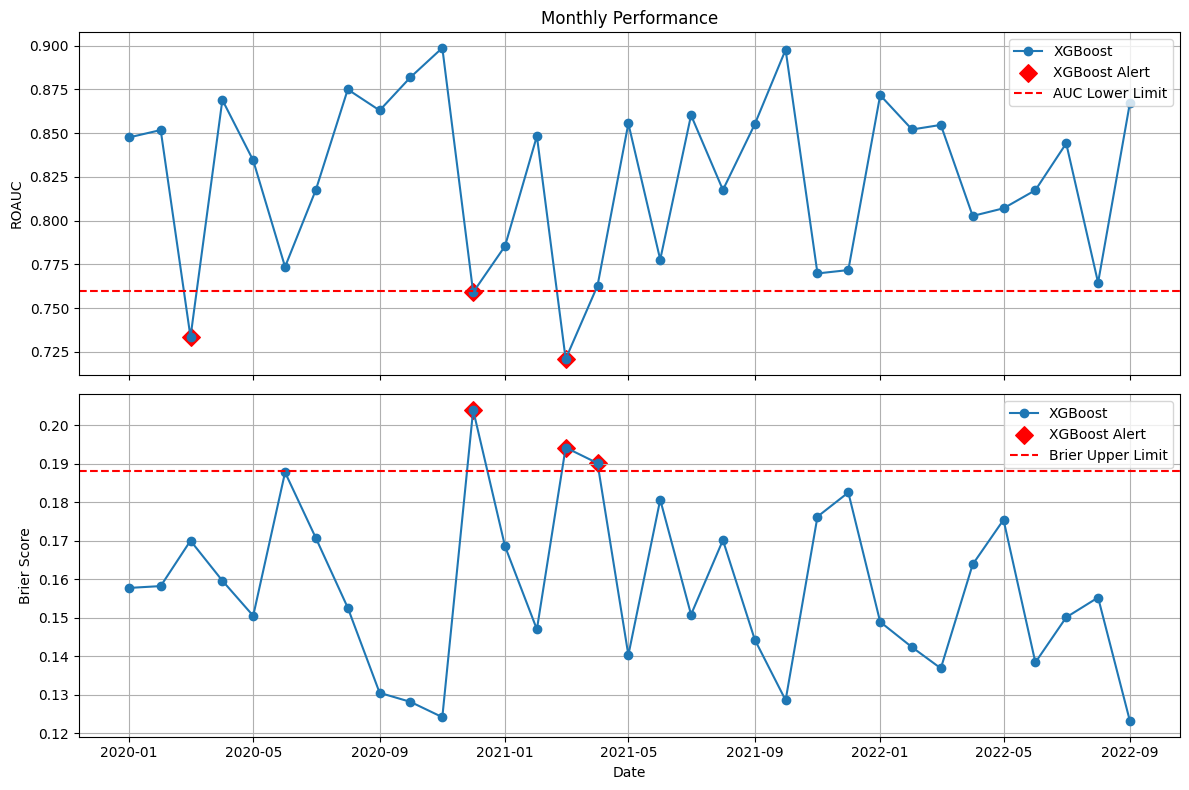

In [ ]:
fig = temporal_validation.plot_period_performance(mark_alerts=True)
fig.show()

### Combined plot
Plot showing calibration and period performance, giving a overview of overall model performance

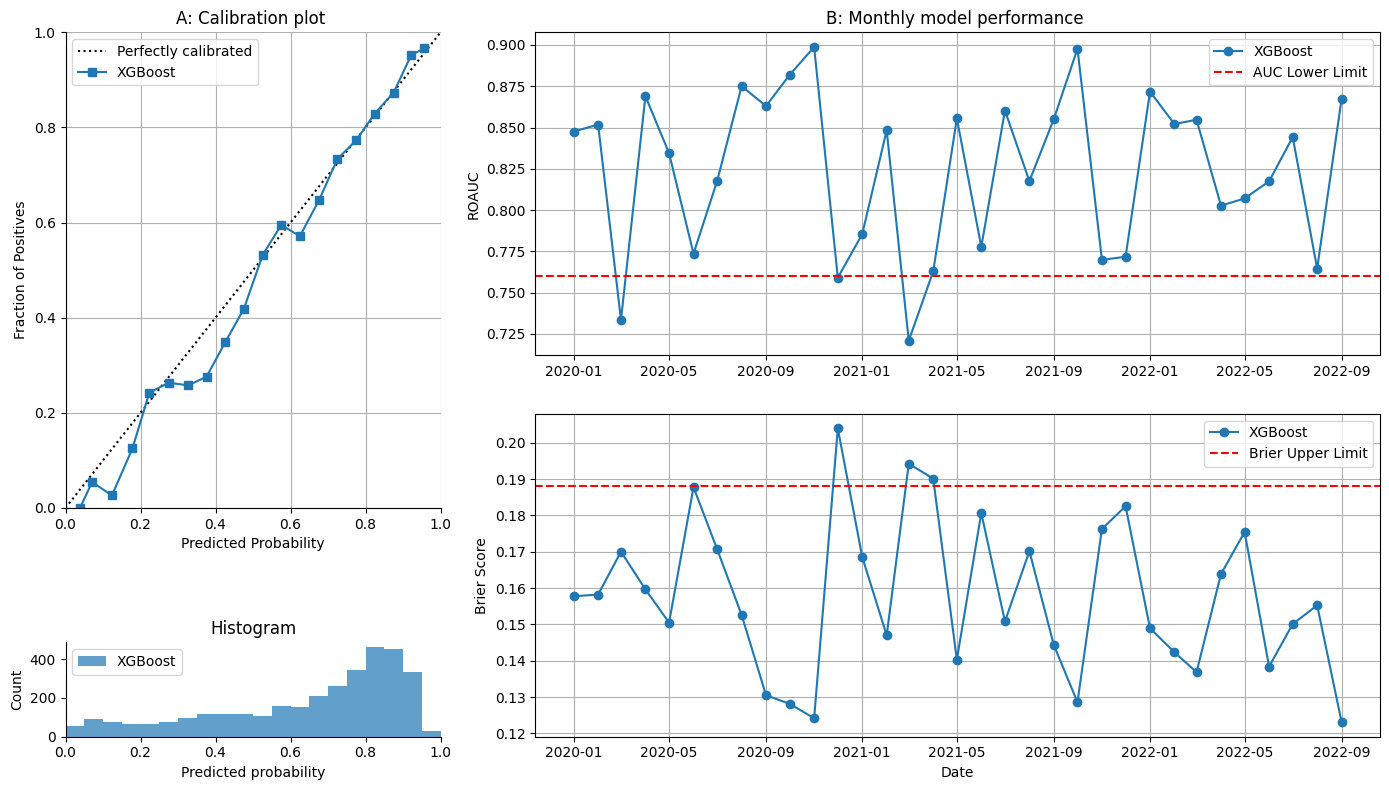

In [ ]:
fig = temporal_validation.plot_combined_curves(data=test_data, plot_brier=True, mark_alerts=False)
fig.show()

## 2. Data Drift Monitoring

In [ ]:
# Rename model column to match article
X_train_renamed = X_train.rename(columns=RENAME_LABELS_DICT)
X_test_renamed = X_test.rename(columns=RENAME_LABELS_DICT)


# Initialize and run the data drift monitor
drift_monitor = DataDriftMonitor(
    timestamp_column="admission_start_time", chunk_period="M", categorical_features=CATEGORICAL_FEATURES_RENAMED
)

### Univariate monitoring

In [ ]:
drift_monitor.set_reference_data(X_train_renamed.drop(columns=["Hospital"]))
drift_monitor.set_analysis_data(X_test_renamed.drop(columns=["Hospital"]))
drift_monitor.run_univariate_drift()

INFO:model_monitoring.data_monitoring:Reference data set with 3438 rows
INFO:model_monitoring.data_monitoring:Analysis data set with 3384 rows
INFO:model_monitoring.data_monitoring:Running univariate drift detection on 17 columns


#### Get univariate alert features
Get all features where there is univariate drift

In [ ]:
drift_monitor.get_univariate_features()

['BMI',
 'Duration of surgery (min)',
 'Length of stay before surgery',
 'Respiratory rate',
 'Radiologic intervention between surgery and prediction time',
 'IV antibiotics between surgery and prediction time',
 'Minimal invasive surgery']

#### Get univariate alert periods
Extract all periods where there is an univariate data drift

In [ ]:
drift_monitor.get_univariate_alert_periods()

['2020-04',
 '2020-08',
 '2020-09',
 '2021-02',
 '2021-06',
 '2021-07',
 '2021-09',
 '2022-01',
 '2022-02',
 '2022-03',
 '2022-04',
 '2022-05',
 '2022-06',
 '2022-07',
 '2022-08',
 '2022-09']

#### Get univariate alert features by period
For each period with an alert, output which feature has univariate drift

In [ ]:
with pd.option_context("display.max_colwidth", 100):
    display(drift_monitor.get_univariate_alerts_by_period())

alert_columns
period                                                                         
2020-04                                             [Duration of surgery (min)]
2020-08                                         [Length of stay before surgery]
2020-09                                              [Minimal invasive surgery]
2021-02                            [Respiratory rate, Minimal invasive surgery]
2021-06                                                      [Respiratory rate]
2021-07           [Radiologic intervention between surgery and prediction time]
2021-09                                              [Minimal invasive surgery]
2022-01                                                      [Respiratory rate]
2022-02                                                      [Respiratory rate]
2022-03                                                 [BMI, Respiratory rate]
2022-04                                                      [Respiratory rate]
2022-05                                                      [Respiratory rate]
2022-06                                                      [Respiratory rate]
2022-07                                                      [Respiratory rate]
2022-08                                                      [Respiratory rate]
2022-09  [Respiratory rate, IV antibiotics between surgery and prediction time]

### Plot univariate data drift
Plot all columns that have univariate data drift

In [ ]:
drift_monitor.plot_univariate_drift(column_names=drift_monitor.get_univariate_features())

### Plot univariate distributions
Plot the distributions of features that have univariate alerts

In [ ]:
drift_monitor.plot_univariate_distributions_for_alerts()

INFO:model_monitoring.data_monitoring:Plotting distributions for columns with alerts: BMI, Duration of surgery (min), Length of stay before surgery, Respiratory rate, Radiologic intervention between surgery and prediction time, IV antibiotics between surgery and prediction time, Minimal invasive surgery


### Multivariate

In [ ]:
drift_monitor.run_multivariate_drift()

INFO:model_monitoring.data_monitoring:Running multivariate drift detection on 17 columns


Months that have multivariate data drift

In [ ]:
drift_monitor.get_multivariate_alerts()

['2020-01', '2021-03', '2021-08', '2022-01']

In [ ]:
drift_monitor.plot_multivariate_drift()

In [ ]:
drift_monitor.generate_drift_summary()

{'univariate': {'alerts_detected': 7,
  'alert_columns': ['BMI',
   'Duration of surgery (min)',
   'Length of stay before surgery',
   'Respiratory rate',
   'Radiologic intervention between surgery and prediction time',
   'IV antibiotics between surgery and prediction time',
   'Minimal invasive surgery'],
  'alert_periods': ['2020-04',
   '2020-08',
   '2020-09',
   '2021-02',
   '2021-06',
   '2021-07',
   '2021-09',
   '2022-01',
   '2022-02',
   '2022-03',
   '2022-04',
   '2022-05',
   '2022-06',
   '2022-07',
   '2022-08',
   '2022-09'],
  'alerts_by_period': {'2020-04': ['Duration of surgery (min)'],
   '2020-08': ['Length of stay before surgery'],
   '2020-09': ['Minimal invasive surgery'],
   '2021-02': ['Respiratory rate', 'Minimal invasive surgery'],
   '2021-06': ['Respiratory rate'],
   '2021-07': ['Radiologic intervention between surgery and prediction time'],
   '2021-09': ['Minimal invasive surgery'],
   '2022-01': ['Respiratory rate'],
   '2022-02': ['Respiratory ra